# Master Statistique et Big Data - Projet d'Optimisation

### Jeremy Bron

## Description du jeu de données

Source des données : https://www.kaggle.com/karangadiya/fifa19
        
Le jeu de données est issu du jeu vidéo FIFA 19, il contient tous les attributs de chaque joueur, soit 18207 et 89 variables.
En détail :
- Des variables texte ou catégorielles identifiant le joueur (Name, Nationality, Club, etc.)
- Les caractéristiques physiques des joueurs (Age, Height, Weight, etc.) 
- Son niveau de performance global (Overall, potentiel, etc.) avec des entiers compris entre 0 et 100 
- Ces performances plus spécifiques (Marking, Dribbling, Contrôle, etc) avec des entiers compris entre 0 et 5
- Son type de jeux ou position sur le terrain et d’autres caractéristiques physiques représenté par des variables catégorielles (Body type, Work rate, etc.9
- Des variables indiquant leur valeurs et rémunérations (entiers à recoder)

La données de contienne pas de variable cible particulières, l'on pourra donc selectiooner certains attribus interessant pour y appliquer les algorythmes suivants:
- Variable Overall (entier) : regression linéaire
- Variable Wages (entier) : regression linéaire
- Variable Major_Nation (catégoriel) regression logistique

_Chargement des données et des packages:_

In [517]:
folder = "C:\\Users\\jb\\Google Drive\\BIG DATA DAUPHINE\\Optimisation\\"

In [518]:
#Packages
import pandas as pd
import numpy as np
from scipy import io
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.plotly as py
from scipy import io
import scipy as scipy
import missingno as msno


In [519]:
df_FIFA = pd.read_csv(folder + "data.csv")
class_names = df_FIFA.columns
df_FIFA.shape #(18207, 89)

(18207, 89)

## Preprosessing et exploration des données

### Données manquantes

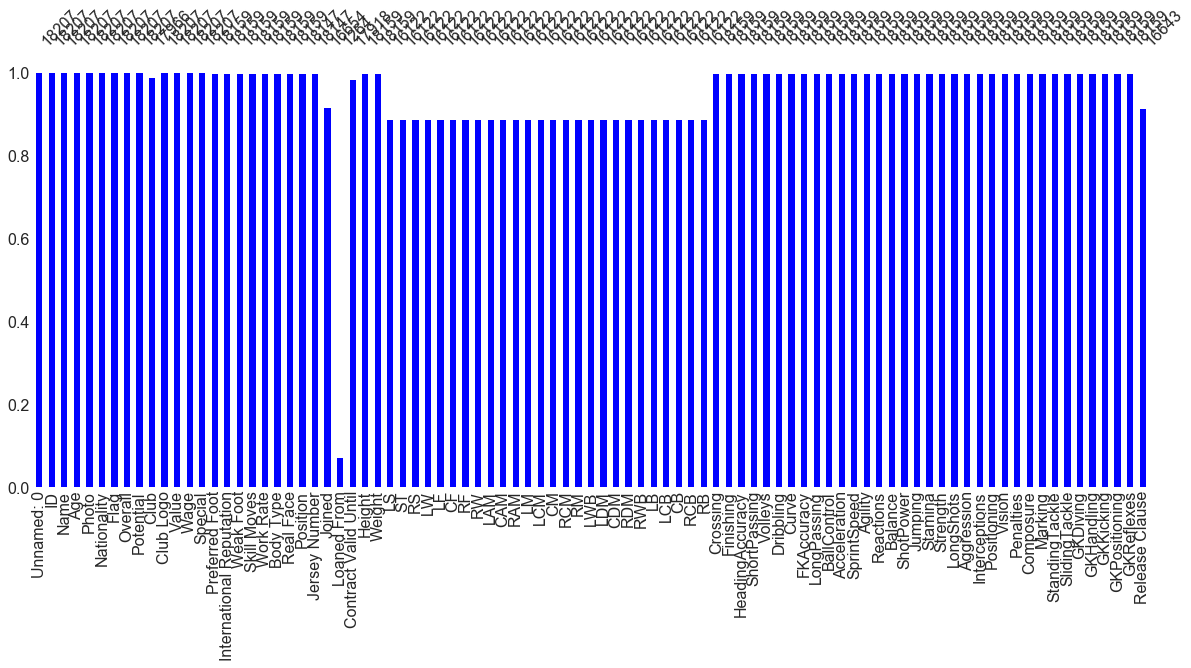

In [520]:
msno.bar(df_FIFA.sample( 18207 ),(20,8),color='blue')

La figure ci dessus indique illustre la proportion de données manquant par variables.
On constate une une quatité importante de données manquantes pour les variables Loaned_From et Jersey_Number

### Preprocessing :

**Pour exploiter les données nous avons effectué les retraitements suivants :**
- Les variables numériques monétaires (Wages, Value, etc.)  qui contiennent du texte pour indiquer l’unité (K pour milliers, M pour millions, etc.) sont modifiés et passés au log
- Simplification de variables catégorielles (Position) avec regroupement de classes (5 au lieu d’une vingtaine) 
- Création d’une variable indicatrice major_nation, basé sur les pays de chaque joueur si la nation est représentée par plus de 250 individus
- Création de dummies pour les variables catégorielles
- Suppression des variables catégorielles ou teste les moins pertinentes pour nos analyses
- Suppression des variables avec beaucoup de données manquantes 
- Suppression des colonnes 28 à 54 car ces attribus des joueurs sont redondant avec les autres et non exploitable (voir tableaux ci-dessous)

Nous avons choisi de ne pas imputer les données manquantes restantes sur les autres variables et de supprimer les individus, car :
- L’imputation par la moyenne d’est pas forcements pertinents pour les caractéristiques peuvent être fortement dépendant du type de joueur, notamment pour ceux en position de goal
- Nous avons déjà beaucoup d’individus et les algorithmes de réduction de la dimension donneront des résultats plus visibles si l’on diminue un peu le nombre d’individus 


In [521]:
df_FIFA[df_FIFA.columns[28:54]].head()

,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,...,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2
1,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,...,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


_Code preprocessing:_

In [522]:
#pour remetre les valeurs dans des formats exploitable
def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value

In [523]:
#DROP UNNECESSARY VALUES
df_FIFA = pd.read_csv(folder + "data.csv")
drop_cols = df_FIFA.columns[28:54]
df_FIFA = df_FIFA.drop(drop_cols, axis = 1)
df_FIFA = df_FIFA.drop(['Name','Club','Unnamed: 0','ID','Photo','Flag','Club Logo','Jersey Number','Joined','Special','Loaned From','Body Type',
               'Contract Valid Until'], axis = 1)
#on choisi de ne pas imputer par la moyenne 
df_FIFA = df_FIFA.dropna()

df_FIFA['Value'] = df_FIFA['Value'].apply(value_to_int)
df_FIFA['Wage'] = df_FIFA['Wage'].apply(value_to_int)
df_FIFA['Release Clause'] = df_FIFA['Release Clause'].apply(value_to_int)


#Turn Real Face into a binary indicator variable
def face_to_num(df_FIFA):
    if (df_FIFA['Real Face'] == 'Yes'):
        return 1
    else:
        return 0
    
#Turn Preferred Foot into a binary indicator variable
def right_footed(df_FIFA):
    if (df_FIFA['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0
    
#Create a simplified position varaible to account for all player positions
def simple_position(df_FIFA):
    if (df_FIFA['Position'] == 'GK'):
        return 'GK'
    elif ((df_FIFA['Position'] == 'RB') | (df_FIFA['Position'] == 'LB') | (df_FIFA['Position'] == 'CB') | (df_FIFA['Position'] == 'LCB') | (df_FIFA['Position'] == 'RCB') | (df_FIFA['Position'] == 'RWB') | (df_FIFA['Position'] == 'LWB') ):
        return 'DF'
    elif ((df_FIFA['Position'] == 'LDM') | (df_FIFA['Position'] == 'CDM') | (df_FIFA['Position'] == 'RDM')):
        return 'DM'
    elif ((df_FIFA['Position'] == 'LM') | (df_FIFA['Position'] == 'LCM') | (df_FIFA['Position'] == 'CM') | (df_FIFA['Position'] == 'RCM') | (df_FIFA['Position'] == 'RM')):
        return 'MF'
    elif ((df_FIFA['Position'] == 'LAM') | (df_FIFA['Position'] == 'CAM') | (df_FIFA['Position'] == 'RAM') | (df_FIFA['Position'] == 'LW') | (df_FIFA['Position'] == 'RW')):
        return 'AM'
    elif ((df_FIFA['Position'] == 'RS') | (df_FIFA['Position'] == 'ST') | (df_FIFA['Position'] == 'LS') | (df_FIFA['Position'] == 'CF') | (df_FIFA['Position'] == 'LF') | (df_FIFA['Position'] == 'RF')):
        return 'ST'
    else:
        return df_FIFA.Position
 
#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)

nat_counts = df_FIFA.Nationality.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df_FIFA):
    if (df_FIFA.Nationality in nat_list):
        return 1
    else:
        return 0

#Create a copy of the original dataframe to avoid indexing errors
df_FIFA1 = df_FIFA.copy()

#Apply changes to dataset to create new column
df_FIFA1['Real_Face'] = df_FIFA1.apply(face_to_num, axis=1).astype("uint8")
df_FIFA1['Right_Foot'] = df_FIFA1.apply(right_footed, axis=1).astype("uint8")
df_FIFA1['Simple_Position'] = df_FIFA1.apply(simple_position,axis = 1)
df_FIFA1['Major_Nation'] = df_FIFA1.apply(major_nation,axis = 1).astype("uint8")

#Split the Work Rate Column in two
tempwork = df_FIFA1["Work Rate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
df_FIFA1["WorkRate1"]= tempwork[0]   
#Create new column for second work rate
df_FIFA1["WorkRate2"]= tempwork[1]
#Drop original columns used
df_FIFA1 = df_FIFA1.drop(['Work Rate','Preferred Foot','Real Face', 'Position','Nationality'], axis = 1)


#Convert Weight and Height to float and metric system 
Weight = df_FIFA1["Weight"].str.split("lbs", n = 1, expand = True) 
df_FIFA1['Weight'] = Weight[0].astype(int) * 0.453592

Height = df_FIFA1["Height"].str.split("'", n = 1, expand = True) 
df_FIFA1["Height"] = Height[0].astype(int) * 0.3048 + Height[1].astype(int) * 0.0254

#Create dummy variables for categorical variables
Simple_Position = pd.get_dummies(df_FIFA1["Simple_Position"], prefix = "Simple_Position" ,drop_first=False)
df_FIFA1 = pd.concat([df_FIFA1, Simple_Position], axis=1)

WorkRate1 = pd.get_dummies(df_FIFA1["WorkRate1"], prefix = "WorkRate1" ,drop_first=False)
df_FIFA1 = pd.concat([df_FIFA1, WorkRate1], axis=1)

WorkRate2 = pd.get_dummies(df_FIFA1["WorkRate2"], prefix = "WorkRate2" ,drop_first=False)
df_FIFA1 = pd.concat([df_FIFA1, WorkRate2], axis=1)

#df_FIFA1 = df_FIFA1.drop(['WorkRate2', 'Simple_Position','WorkRate1'], axis = 1)

#On passe les variables monetaire (salaire, valeur du joueur) en log avant de scale sur le train test car difficile d apprendre sur les valeurs extremes.
df_FIFA1['Value'] = np.log(df_FIFA1['Value'])
df_FIFA1['Wage'] = np.log(df_FIFA1['Wage'])
df_FIFA1['Release Clause'] = np.log(df_FIFA1['Release Clause'])

#df_FIFA1.head()

#differentypes de int pour des bools, peut etre vaut le coup de changer ca si problemes de memoire

### Visualisation des données

La distribution des données utilisées pour les modélisations suivantes est illustrée dans la figure ci-dessous, on note que :
- La variable indiquant un niveau de performances globales (Overall, Potential) a une distribution plutôt gaussienne
- Les variables indiquant des niveaux de performances spécifiques semblent avoir une distribution composée d’un ou deux gaussiennes qui se superpose plus ou moins bien.  Les distributions à deux gaussiennes sont particulièrement dues à la présence de joueurs « normaux » et de « goal » (position GK) dont les forces et la faiblesse se répartissent différemment. Cela se remarque notamment sur les avec le préfixe « GK » et sur certaines variables comme StandingTackle, etc.
- Les variables Value, Wages et Release représentent des sommes d’argent et sont illustrés en échelles log. On constate que Value et la Release Clause se rapproche de gaussiens faussés vers la droite, relativement semblable à une loi de Pareto prise au log. La variable Wages à une distribution plutôt concertée vers des valeurs « faibles » avec la plupart des salaires à un niveau de base et une diminution quasi exponentielle (linéaire sur le log) du nombre de joueurs avec de hauts salaires


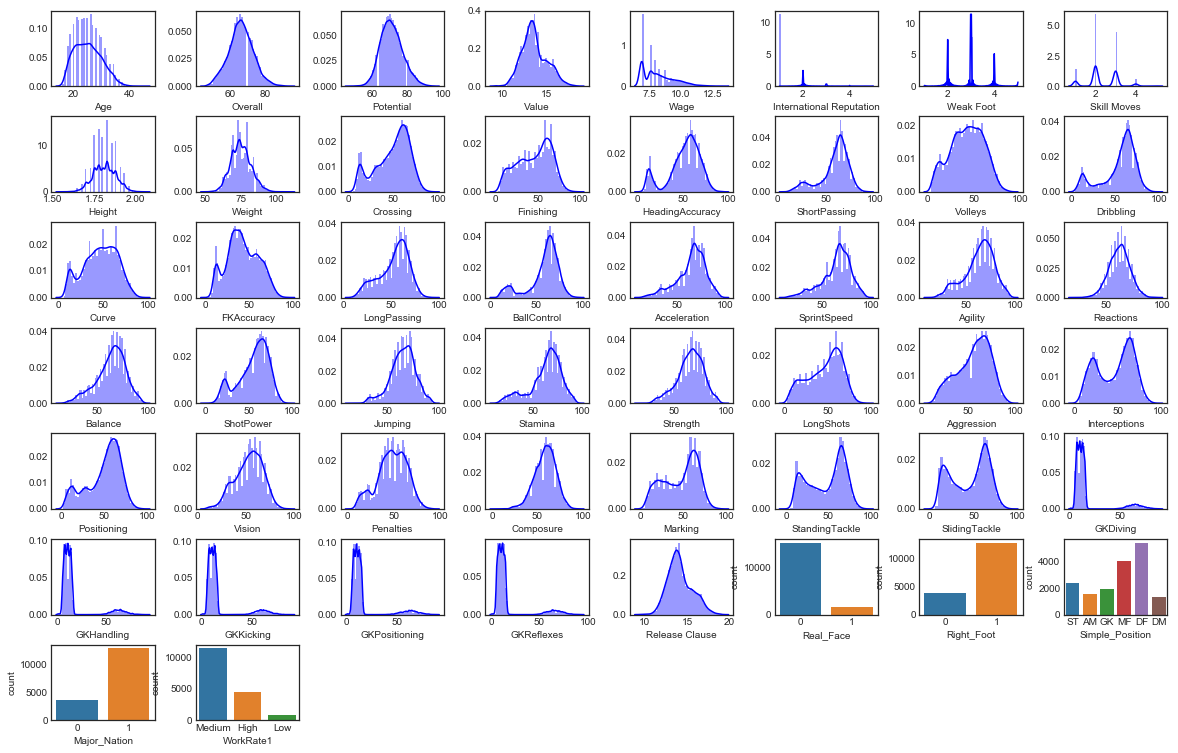

In [524]:
warnings.filterwarnings(action='ignore')

df_Graph = df_FIFA1.iloc[:,:51]

#df_Graph['Value'] = np.exp(df_Graph['Value'])
#df_Graph['Wage'] = np.exp(df_Graph['Wage'])
#df_Graph['Release Clause'] = np.exp(df_Graph['Release Clause'])


plt.figure(figsize=(20,15))
plt.clf
plt.style.use('seaborn-white')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k=0
nbFig = 1
for i in np.arange(0,8):
    for j in np.arange(0,8):
        if k<df_Graph.shape[1]-1:
            plt.subplot(8,8,nbFig)
            if df_Graph.dtypes[k]=="float64" or df_Graph.dtypes[k]=="int64":
                sns.distplot(df_Graph.iloc[:,k], color = 'blue')
                nbFig = nbFig + 1               
            elif df_Graph.dtypes[k]=="object" or df_Graph.dtypes[k]=="uint8":
                sns.countplot(x=df_Graph.columns[k], data=df_Graph)
                nbFig = nbFig + 1
            k = k+1

In [572]:
df_FIFA2 = df_FIFA1.drop(['WorkRate2', 'Simple_Position','WorkRate1'], axis = 1)

#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]


np.random.seed(111)

A = np.array(df_FIFA2)
A = A[np.random.permutation(A.shape[0]),:]

class_name_all = df_FIFA2.columns

mask = np.ones(class_name_all.shape[0],dtype=bool)

#retirer la target
mask[find(class_name_all == 'Overall')[0]] = 0

X = A[:,mask]
[n,p] = X.shape

#retirer les variable catégories
X_cat = X[:,44:]
X = X[:,:44]


y = MakeCol(A[:,find(class_name_all == 'Overall')[0]])
c = MakeCol(np.random.random_sample(X.shape[0]))

ech = .30

I0 = find(c>ech) # train
I1 = find(c<=ech) # test
n0 = I0.size
n1 = n-n0
X0 = X[I0,:]
y0 = y[I0]
X1 = X[I1,:]
y1 = y[I1]

#nomalisation du train
mX0 = X0.mean(axis=0)
sX0 = X0.std(axis=0)
X0 = (X0-mX0)/sX0
X1 = (X1-mX0)/sX0
m0 = y0.mean()
y0 = y0-m0
y1 = y1-m0

#remetre les variables catégorielles
X0 = np.append(X0,X_cat[I0,:], axis=1)
X1 = np.append(X1,X_cat[I1,:], axis=1)

la normalisation n'est faites que sur les variables numérique, on remet les variables catégorielles (dummies) dans le jeu de données apres la normalisation.

## Matrice de Corrélation

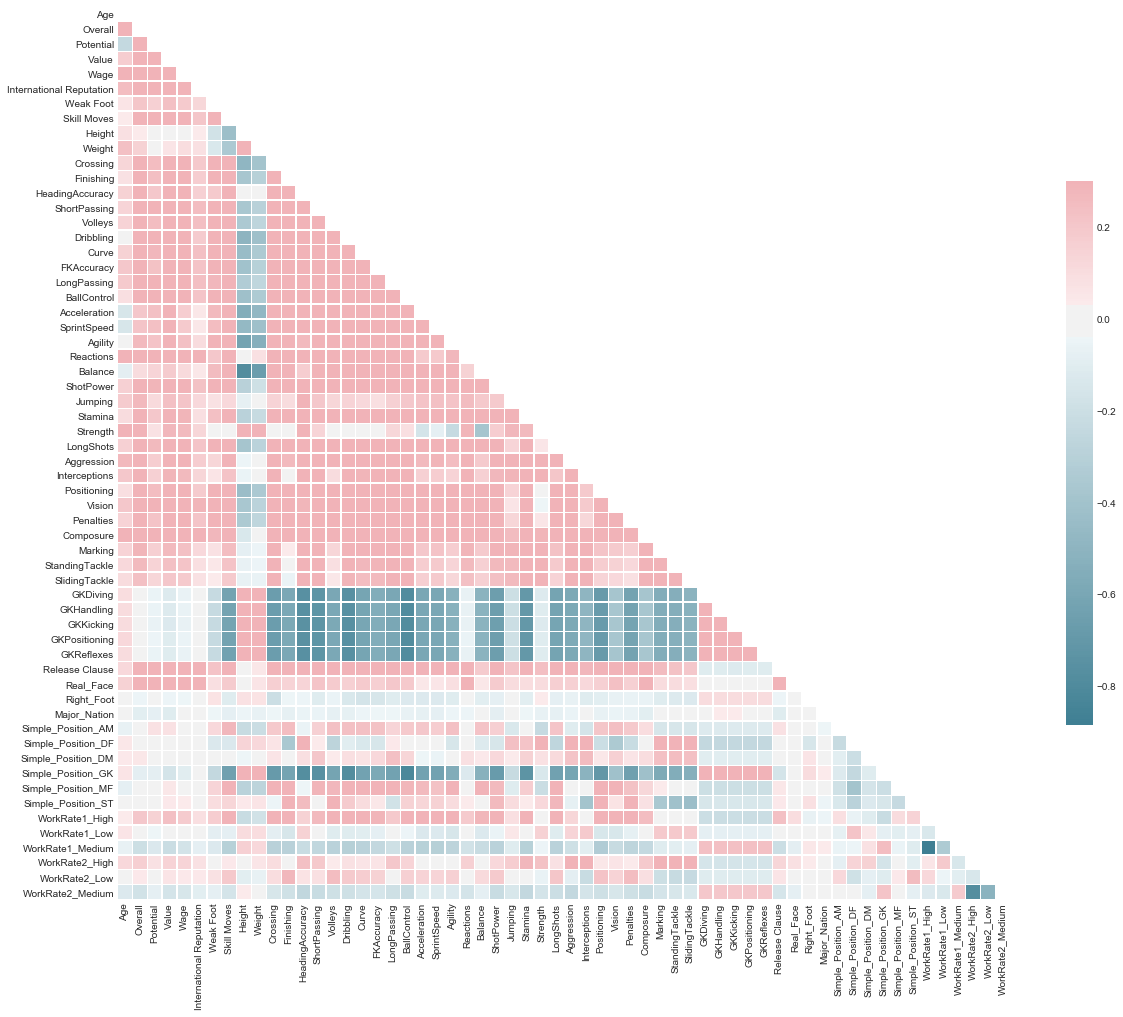

In [573]:
# matrice de correlation 
col_label = df_FIFA2.columns

X0c = df_FIFA2
corr = X0c.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels =col_label , yticklabels= col_label)

**La visualisation de la matrice de corrélation permet de dégager les éléments suivants :**

- Les statistiques décrivant la performance des joueurs sont dans l’ensemble toutes corrélées positivement entre elles autour de 0.2. Les bons joueurs ont tendances à être plutôt "bon partout dans l'ensemble" et vis versa pour les moins bons joueurs. 
- Certaines variables comme le poids et la taille (qui sont liés) sont-ils anti corrélée à la plupart des variables de performance des joueurs (sauf la force)
- Les variables de GK (goal Keeper) sont toutes anti corrélée avec les variables de performance "sur le terrain" ce qui semble également logique.
- On remarque que wages et value sont seulement corrélé à 0.2 (ce qui pourrait être contre-intuitif pour ce sport).
- L'âge et le potentiel sont anti corrélés, etc...

La nature des variables les rends intrinsèquement assez dépendantes entre elles, cela se retrouve dons dans les niveaux de corrélation relativement élevés. 
Comme le jeu de donnée n’impose pas de cible particulière pour la modélisation, on pourra faire plusieurs tests. Cela permettra de bien comprendre le fonctionnement des algorithmes de réduction de la dimension qui n’ont pas forcement un comportement stable lorsque les variables sont tres corrélées entres elles



# ACP 

L'analyse par composante principale est calculé à l'aide de la décomposition en valeur singulière de numpy (SVD). Cette implémentation est plus efficasse, surtout pour dans gros jeux de données.

In [574]:
#compute pca
U, s, V = np.linalg.svd(X0 , full_matrices= True)
X0r = X0.dot( V.transpose() )

Text(0.5, 1.0, 'Variance explicative cumulée')

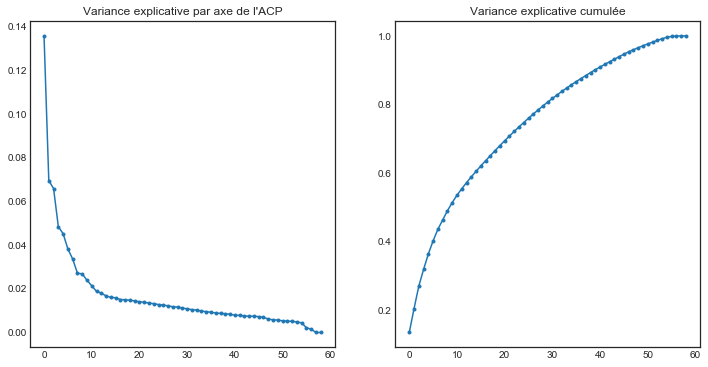

In [575]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(s/sum(s), '.-')
plt.title("Variance explicative par axe de l'ACP")
plt.subplot(1,2,2)
plt.plot(np.cumsum(s)/sum(s), '.-' )
plt.title("Variance explicative cumulée")

**Interprétation de l'ACP :**
- Le premier axe capte une forte part de l’inertie totale avec presque 14% 
- Les deux axes suivants captent environ 7% chacun de l’inertie ; les deux suivants environ 5% chacun ; puis 3,5% chacun pour les deux suivants. Soit 44% de l’inertie totale regroupée dans les 7 premiers axes de l’ACP. 
-  Pour les axes suivants, on peut observer de façon immédiate la « coupure » de la règle du coude de l’ACP


Text(0.5, 1.0, "Projection des indivudus sur les deux premiers axes de l'ACP")

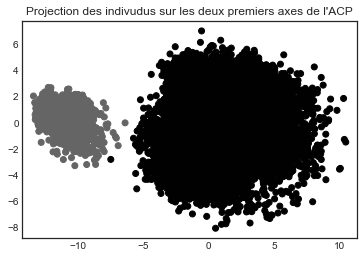

In [576]:
color = [str((1+item*100)/255.) for item in X0[:,50]]

plt.scatter(X0r[:,0], X0r[:,1], c = color)
plt.axis('equal')
plt.title("Projection des indivudus sur les deux premiers axes de l'ACP")

**Projection sur les axes 1 et 2 de l'ACP**

Les points de l'ACP sur les deux premiers axes sont colorés selon la variable indicatrice de la position du joueur en tant que goal (GK).

On observe deux groupes de points très distincts : un pour les joueurs (en noir) et l'autre pour les goals (en gris). 

La projection sur les deux premiers axes de l'ACP a réussi à séparer ces points dont les caractéristiques de performances sont assez différentes.

Text(0.5, 1.0, "Projection des individus sur les axes 2 et 3 de l'ACP")

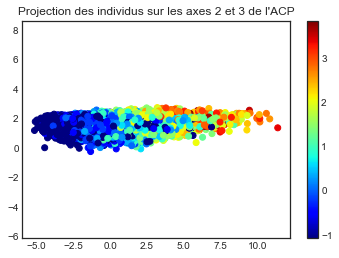

In [577]:
plt.scatter(X0r[:,2], X0r[:,3], c = X0[:,3],cmap="jet")
plt.colorbar()
plt.axis('equal');
plt.title("Projection des individus sur les axes 2 et 3 de l'ACP")


**Projection sur les axes 3 et 4 de l'ACP**

- Les individus sont colorés selon la variable Value
- On constate que le 3eme axe de l'ACP sépare bien les joureurs selon leur valeur





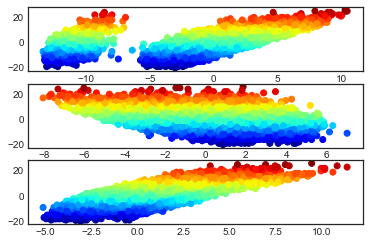

In [578]:
plt.clf
for i in np.arange(0,3):
    plt.subplot(3,1,i+1)
    plt.scatter(X0r[:,i], y0, c = y0,cmap="jet")
    plt.axis('tight')

**Diagramme 1D de la cible (y0) le long des principaux axes de l'ACP**
- Les points sont égalements colorés selon la valeur de y0
- Pour l'axe 3 de l'ACP on observe une relation linéaire entre la valeur de la cible et la projection sur cette axe. On a vu précédement que cet axe sépare bien les individus selon la variables Value, celle ci est correlé à la cible (variable Overall) et l'on peut directement observer ces relation entre les données ici.

# Modèle linéaire

Nous recherchons une relation linéaire
  $y_i = \dotp{w}{x_i}$
écrit sous forme matricielle
  $ y= X w $
où les lignes de $X \in \RR^{n \times p}$ stocke les variables $x_i \in \RR^p$.

Etant donnée que $ n > p $, il s'agit d'un système surdéterminé, qui peut
être résolue par la méthode des moindres carrées
  $$ \umin{ w }  \norm{Xw-y}^2 $$
  
dont la solution est donnée en utilisant la pseudo-inverse de Moore-Penrose
  $$ w = (X^\top X)^{-1} X^\top y $$


## Prédiction et régularisation sur la variable "Overall"

In [579]:
w = np.linalg.solve( X0.transpose().dot(X0), X0.transpose().dot(y0) )
wx = w

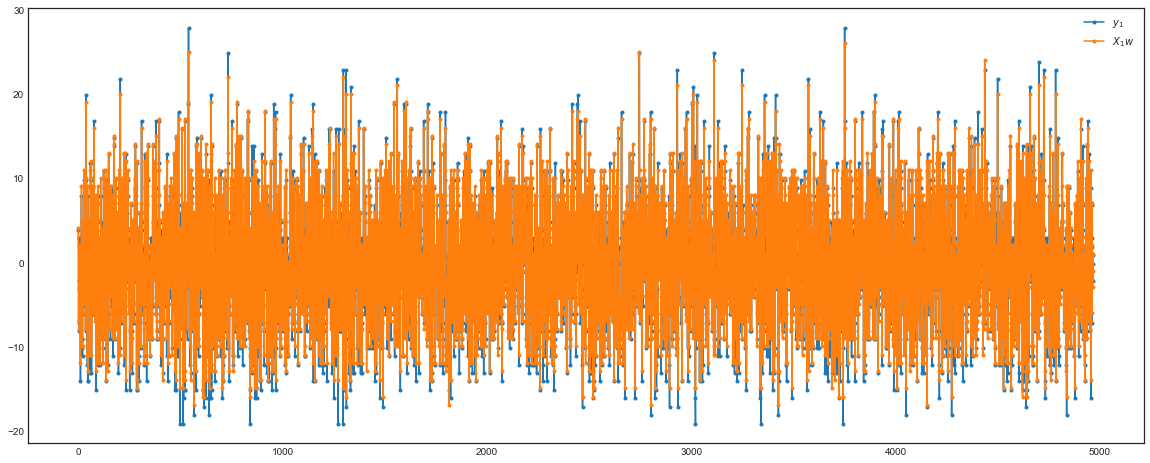

In [580]:
plt.clf
plt.figure(figsize=(20,8))
plt.plot( y1 , '.-' )
plt.plot( (X1.dot(w)).round(0) , '.-' )
plt.axis('tight')
plt.legend(('$y_1$', '$X_1 w$'));

**Plot de la prédiction sur le jeu de test et des vraies valeurs y1**

Visiblement les prédictions sont très proches du jeu de test


In [581]:
E = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
print(( 'Relative prediction error: ' + str(E) ) );

Relative prediction error: 0.13353393687322818


L'erreur de préduction est faible. Nous regardons si la réduction de dimention peut encore améliorer le résultat.

**Régularisation Ridge**

La régularisation est obtenue par l'introduction d'une pénalité appelée régression Ridge et qui définie comme suit
  $$ \umin{ w }  \norm{Xw-y}^2 + \lambda \norm{w}^2 $$
ou $\lambda>0$ est le paramètre de régularisation.


La solution est donnée à l'aide de la formule  suivante
  $$ w = (X^\top X + \lambda \text{Id}_p )^{-1} X^\top y, $$
  $$ w = X^\top ( XX^\top + \lambda \text{Id}_n)^{-1} y, $$
Quand $p<n$ (ce qui est le cas ici), la première formule devrait être
préférée.



In [582]:
Lambda = .2*np.linalg.norm(X0)**2;
w = np.linalg.solve( X0.transpose().dot(X0) + Lambda*np.eye(p), X0.transpose().dot(y0) )
u = np.linalg.solve( X0.dot(X0.transpose()) + Lambda*np.eye(n0), y0)
w1 = X0.transpose().dot( u )
print( ('Error (should be 0): ' + str( np.linalg.norm(w-w1)/np.linalg.norm(w) ) ) )

Error (should be 0): 3.637223506040248e-15


La comparaison des deux algorithmes définis précédemment tend correctement vers 0.

In [583]:
np.linalg.norm(X0,2)**2

245885.5764704453

Ridge: 13.351976429330644%


Text(0, 0.5, '$E$')

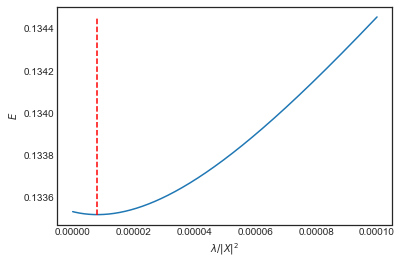

In [584]:
q = 1000
lmax = np.linalg.norm(X0,2)**2
lambda_list = lmax*np.linspace(1e-4,1e-15,q)
W = np.zeros( (p,q) )
E = np.zeros( (q,1) )
for i in np.arange(0,q):
    Lambda = lambda_list[i]
    w = np.linalg.solve( X0.transpose().dot(X0) + Lambda*np.eye(p), X0.transpose().dot(y0) )
    W[:,i] = w.flatten() # bookkeeping
    E[i] = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
# find optimal lambda
i = E.argmin()
lambda0 = lambda_list[i]
wRidge = W[:,i]
print( 'Ridge: ' + str(E.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(), E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$E$')

**Plot de l'erreur de prédiction en fonction du paramètre $\lambda$:**
- La valeur 'lmax' utilisée pour l'espace des $\lambda$ qui est calculé à partir de $|X|^2$ est très grande (> 240000).
- Le paramètre $\lambda$ est extrêmement sensible et l'ont doit donc se placer dans un range de valeur de très petit par rapport à 'lmax', de l'ordre de $10^{-10}$
- Pour la valeur optimale de $\lambda$, l'erreur diminue d'une quantité de l'ordre de $10^{-3}$, soit une diminution négligeable en comparaison avec l'erreur total d'environ 0.13 .

No handles with labels found to put in legend.


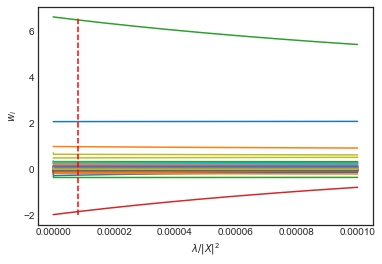

In [585]:
plt.clf
for i in np.arange(0,p):
    plt.plot(lambda_list/lmax, W[i,:]) #, label=col_label[i]
plt.plot( [lambda0/lmax,lambda0/lmax], [W.flatten().min(), W.flatten().max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$w_i$')
plt.legend()

**Plot de la contribution des variables en fonction du paramètre $\lambda$:**
- Très rapidement la régularisation va quasiment supprimer la contribution de certaines variables. 
- Trois variables ont une contribution importante pour à la valeur optimale de l'erreur, ainsi qu'une 10aine d'autres variables donc la contribution est également non négligeable.
- Globalement on constate que l'erreur minimum est atteinte avec une faible valeur de $\lambda$


## Régularisation sparce (Lasso)

Pour effectuer une selection de variable, (un sous ensemble de variable les plus prédictives), il faut remplacer la fonction
$\ell^2$ de pénalité de régularisation par un régularisateur sparce (parcimonieux.  Le
la plus connue est la norme  $\ell^1$ 
$$ \norm{w}_1 \eqdef \sum_i \abs{w_i} . $$


L'énergie à minimiser est
$$ \umin{w} J(w) \eqdef \frac{1}{2}\norm{X w-y}^2 + \lambda \norm{w}_1. $$

In [586]:
def J(w,Lambda): return 1/2*np.linalg.norm(X0.dot(w)-y0)**2 + Lambda*np.linalg.norm(w,1)

Afin de minimiser l'énergie on utilise l'algorythme ISTA (iterative soft thresholding), aka proximal gradient aka
forward-backward.

Chaque itération est effectué à l'aide de l'opérateur:
$$ \Ss_s(x) \eqdef \max( \abs{x}-\lambda,0 ) \text{sign}(x).  $$


In [587]:
def Soft(x,s): return np.maximum( abs(x)-s, np.zeros(x.shape)  ) * np.sign(x)

Ainsi, l'algorithme ISTA se traduit par:
$$ w_{k+1} \eqdef \Ss_{\la\tau}( w_k - \tau X^\top ( X w_k - y )  ), $$

Pour assurer la convergence, la taille du pas doit vérifier: 
$ 0 < \tau < 2/\norm{X}^2  $

In [588]:
tau = 1.5/np.linalg.norm(X0,2)**2
lmax = abs( X0.transpose().dot(y0) ).max()
Lambda = lmax /10

_Implémentation de l'algorithme et vérification de la convergence de l'energie:_

In [589]:
w = np.zeros((p,1))
C = X0.transpose().dot(X0)
u = X0.transpose().dot(y0)
def ISTA(w,Lambda,tau): return Soft( w-tau*( C.dot(w)-u ), Lambda*tau )
w = ISTA(w,Lambda,tau)

Text(0.5, 1.0, '$log(J(w_k)-min J)$')

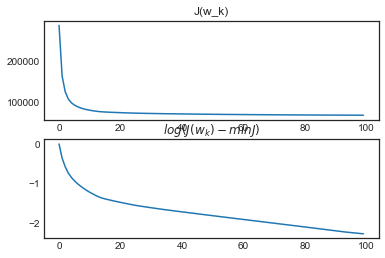

In [590]:
niter = 400
Jlist = np.zeros((niter,1))
w = np.zeros((p,1))
for i in np.arange(0,niter):
    Jlist[i] = J(w,Lambda)
    w = ISTA(w,Lambda,tau)
ndisp = int(niter/4)

plt.clf
plt.subplot(2,1,1)
plt.plot(Jlist[0:ndisp])
plt.axis('tight')
plt.title('J(w_k)')
plt.subplot(2,1,2)
e = np.log10( Jlist[0:ndisp]-Jlist.min() +1e-20)
plt.plot(e-e[0])
plt.axis('tight')
plt.title('$log(J(w_k)-min J)$')

La convergence est assez rapide, en ligne droite sur l'echelle log, typique de la déscente de gradient

Lasso: 13.351021254082788%


Text(0, 0.5, '$E$')

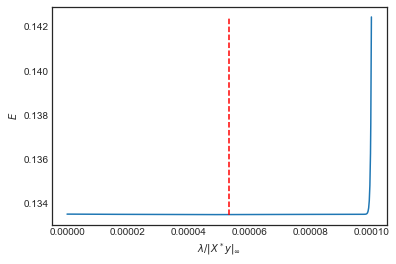

In [591]:
q = 1000
lambda_list = lmax*np.linspace(1e-4,1e-14,q)
W = np.zeros( (p,q) )
E = np.zeros( (q,1) )
w = np.zeros((p,1))
niter = 500
for iq in np.arange(0,q):
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        w = ISTA(w,Lambda,tau)
    W[:,iq] = w.flatten() # bookkeeping
    E[iq] = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
# find optimal Lambda
i = E.argmin()
lambda0 = lambda_list[i]
wSparse = W[:,i]
print( 'Lasso: ' + str(E.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(),E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.ylabel('$E$')


**Plot de l'erreur de prédiction en fonction du paramètre $\lambda$:**
- L'erreur atteind rapidement une valeur minimum pour un $\lambda$ relativement petit
- l'amélioration de l'erreur de prédiction est meilleure qu'avec la régression Ridge, même si cela reste négligeable par rapport à l'erreur totale

No handles with labels found to put in legend.


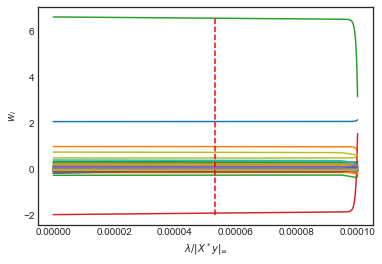

In [592]:
plt.clf
for i in np.arange(0,p):
    plt.plot(lambda_list/lmax, W[i,:])#, label=col_label[i]
plt.plot( [lambda0/lmax,lambda0/lmax], [W.flatten().min(),W.flatten().max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.ylabel('$w_i$')
plt.legend()


**Plot de la contribution des variables en fonction du paramètre $\lambda$:**

- La variation de l’erreur de prédiction en fonction de lambda présente des changements de pente importants. Ces changements de pentes interviennent lorsque la contribution des variables change également de régime (on constate même un changement de signe pour la variable en rouge). Ce comportement est typique variable fortement corrélée.

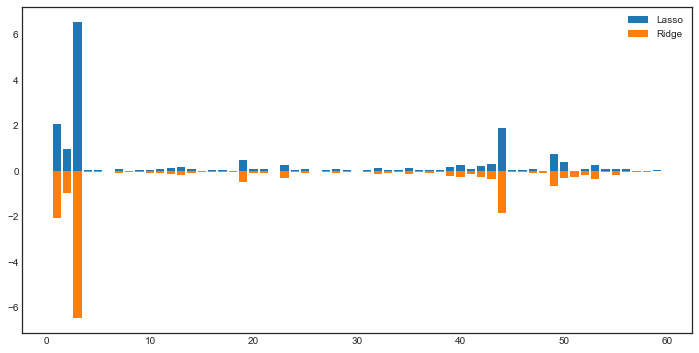

In [593]:
plt.clf
plt.figure(figsize=(12,6))
plt.bar(np.arange(1,p+1), abs(wSparse))
plt.bar(np.arange(1,p+1), -abs(wRidge))
plt.legend(('Lasso', 'Ridge'))


**Comparaison des poids optimaux entre Ridge et Lasso**
- Les poids sont relativement identiques pour les variables les plus importantes 
- Cependant Le Lasso effectue une véritable sélection de variables et conserve moins de variables que le Ridge qui conserve certaines variables avec des poids très petits (mais tout de même visible sur le graphique). 



**Commentaire pour la prédiction de la variable Overall**
- Tous d'abord la régression linéaire classique donne de bon résultat, lorsque l'on regarde les coefficients, on constate que la "sélection de variable" a déjà été faite à ce moment-là 
- Lorsque l'on compare les coefficients avec la régression Ridge on constate que c'est surtout au niveau des demies variables "WorkRate" que les choses changent : WorkRate1 et WorkRate2 semblent se contrebalancer avec des coefficients positifs ou négatifs qui sont (en valeur absolue) très grands dans le modèle linéaire et beaucoup plus petit avec le Ridge

Le choix de la variable Overall, qui est censée être la synthèse des autres variables n'est pas forcement très intéressant, car elle est forcement très corrélés à toutes les autres, et surtout au potentiel ou à la valeur des joueurs. Cela permet cependant de mieux comprendre le fonctionnement des algorithmes dans ces cas limite. Afin d'aller plus loin dans la compréhension ou refait l'exercice pour tenter de prédire cette fois le salaire (variable Wages)



Text(0.5, 1.0, 'Coéficient de la regression Sparce')

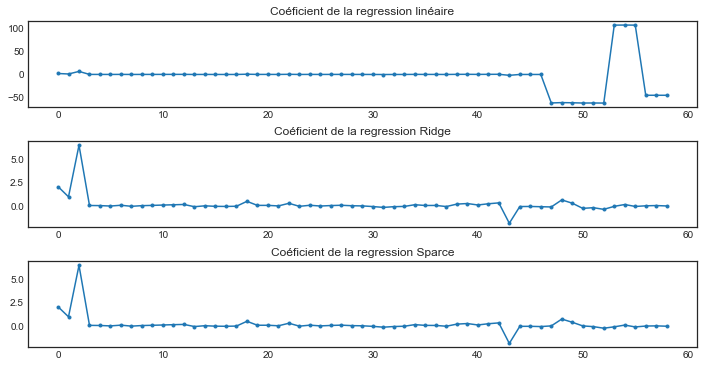

In [594]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.subplot(3,1,1)
plt.plot(wx, '.-')
plt.title("Coéficient de la regression linéaire")
plt.subplot(3,1,2)
plt.plot(wRidge, '.-')
plt.title("Coéficient de la regression Ridge")
plt.subplot(3,1,3)
plt.plot(wSparse, '.-')
plt.title("Coéficient de la regression Sparce")


## Prédiction et régularisation sur la variable "Value"

- La méthodologie précédente est réappliquée pour prédire la variable « Value », pour rappel on à pris le log des données d’origines.
- La variable release clause est retiré, car elle est très semblable à la Value 
- La méthodologie n’est pas détaillée, seulement certains résultats sont commentés
- Afin de voir le comportement des algorithmes dans le cas où le nombre d'individus est réduit par rapport au nombre de variables on choisit de séparer les données avec 99% dans le test et 1% dans le train. Soit un jeu d'entrainement de 163 individus (pour 58 variables).


In [595]:
A = np.array(df_FIFA2)
A = A[np.random.permutation(A.shape[0]),:]

class_name_all = df_FIFA2.columns

mask = np.ones(class_name_all.shape[0],dtype=bool)

#retirer la target et release clause
mask[find(class_name_all == 'Value' )[0]] = 0
mask[find(class_name_all == 'Release Clause' )[0]] = 0


X = A[:,mask]
[n,p] = X.shape

#retirer les variable catégories
X_cat = X[:,43:]
X = X[:,:43]


y = MakeCol(A[:,find(class_name_all == 'Value')[0]])
c = MakeCol(np.random.random_sample(X.shape[0]))

ech = .99

I0 = find(c>ech) # train
I1 = find(c<=ech) # test
n0 = I0.size
n1 = n-n0
X0 = X[I0,:]
y0 = y[I0]
X1 = X[I1,:]
y1 = y[I1]

#nomalisation du train
mX0 = X0.mean(axis=0)
sX0 = X0.std(axis=0)
X0 = (X0-mX0)/sX0
X1 = (X1-mX0)/sX0
m0 = y0.mean()
y0 = y0-m0
y1 = y1-m0

#remetre les variables catégorielles
X0 = np.append(X0,X_cat[I0,:], axis=1)
X1 = np.append(X1,X_cat[I1,:], axis=1)


w = np.linalg.solve( X0.transpose().dot(X0), X0.transpose().dot(y0) )
w1 = w

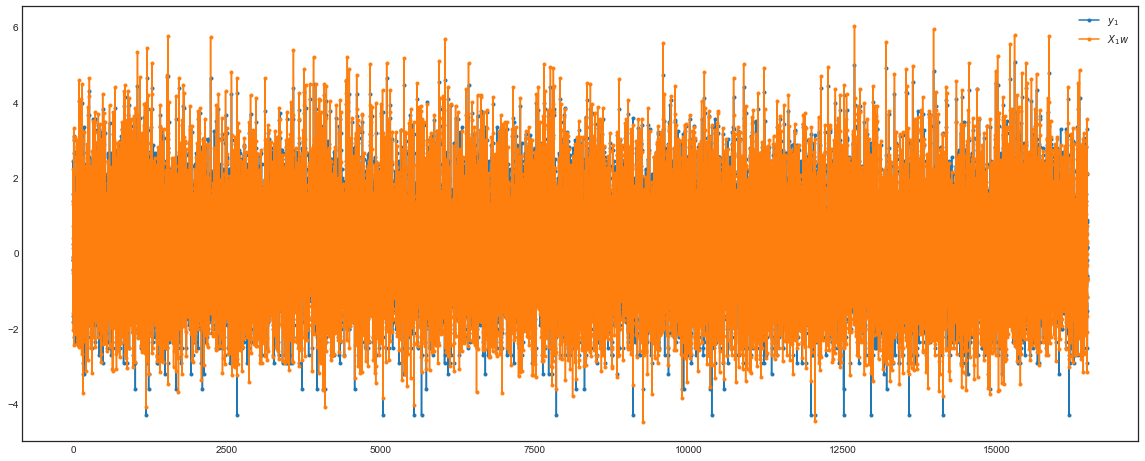

In [596]:
plt.clf
plt.figure(figsize=(20,8))
plt.plot( y1 , '.-' )
plt.plot( (X1.dot(w)).round(3) , '.-' )
plt.axis('tight')
plt.legend(('$y_1$', '$X_1 w$'));

In [597]:
E = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
print(( 'Relative prediction error: ' + str(E) ) );

Relative prediction error: 0.20066328168090858


- On constate que cette variable est plus difficile à prédire même si l'erreur à 20% est relativement bonne pour un jeu d'entrainement si petit.
- En conservant un split train test à 30% comme précédemment l'erreur de prédiction serait d'environ 16%.


Ridge: 18.54649781342276%


Text(0, 0.5, '$E$')

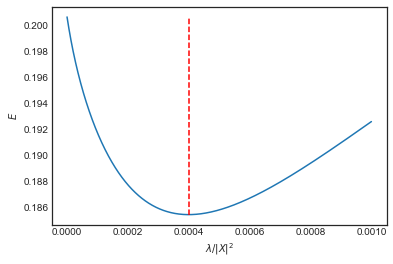

In [598]:
q = 1000
lmax = np.linalg.norm(X0,2)**2
lambda_list = lmax*np.linspace(1e-3,1e-15,q)
W = np.zeros( (p,q) )
E = np.zeros( (q,1) )
for i in np.arange(0,q):
    Lambda = lambda_list[i]
    w = np.linalg.solve( X0.transpose().dot(X0) + Lambda*np.eye(p), X0.transpose().dot(y0) )
    W[:,i] = w.flatten() # bookkeeping
    E[i] = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
# find optimal lambda
i = E.argmin()
lambda0 = lambda_list[i]
wRidge = W[:,i]
print( 'Ridge: ' + str(E.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(), E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$E$')

No handles with labels found to put in legend.


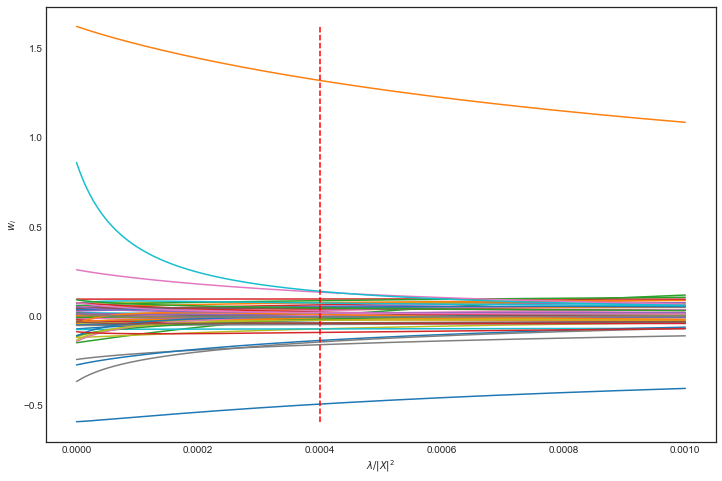

In [599]:
plt.clf
plt.figure(figsize=(12,8))
for i in np.arange(0,p):
    plt.plot(lambda_list/lmax, W[i,:]) #, label=col_label[i]
plt.plot( [lambda0/lmax,lambda0/lmax], [W.flatten().min(), W.flatten().max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X|^2$')
plt.ylabel('$w_i$')
plt.legend()

- La régression Ridge ne permet de gagner environ 1% de précision supplémentaire, ce qui n'est pas négligeable dans ce cas-là.
- De nombreuses variables sont conservées avec des poids importants pour deux d’entre elles, les poids autres variables conservés sont quand même relativement significatifs

Text(0.5, 1.0, '$log(J(w_k)-min J)$')

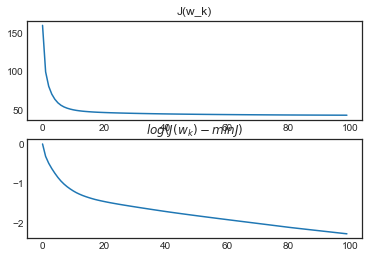

In [600]:
tau = 1.5/np.linalg.norm(X0,2)**2
lmax = abs( X0.transpose().dot(y0) ).max()
Lambda = lmax /10
w = np.zeros((p,1))
C = X0.transpose().dot(X0)
u = X0.transpose().dot(y0)
def ISTA(w,Lambda,tau): return Soft( w-tau*( C.dot(w)-u ), Lambda*tau )
w = ISTA(w,Lambda,tau)
niter = 400
Jlist = np.zeros((niter,1))
w = np.zeros((p,1))
for i in np.arange(0,niter):
    Jlist[i] = J(w,Lambda)
    w = ISTA(w,Lambda,tau)
ndisp = int(niter/4)

plt.clf
plt.subplot(2,1,1)
plt.plot(Jlist[0:ndisp])
plt.axis('tight')
plt.title('J(w_k)')
plt.subplot(2,1,2)
e = np.log10( Jlist[0:ndisp]-Jlist.min() +1e-20)
plt.plot(e-e[0])
plt.axis('tight')
plt.title('$log(J(w_k)-min J)$')

Comme précédemment l’énergie converge rapidement 

Lasso: 17.216571215217666%


Text(0, 0.5, '$E$')

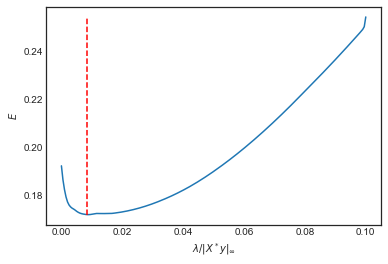

In [604]:
q = 200
lambda_list = lmax*np.linspace(1e-1,1e-10,q)
W = np.zeros( (p,q) )
E = np.zeros( (q,1) )
w = np.zeros((p,1))
niter = 500
for iq in np.arange(0,q):
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        w = ISTA(w,Lambda,tau)
    W[:,iq] = w.flatten() # bookkeeping
    E[iq] = np.linalg.norm(X1.dot(w)-y1) / np.linalg.norm(y1)
# find optimal Lambda
i = E.argmin()
lambda0 = lambda_list[i]
wSparse = W[:,i]
print( 'Lasso: ' + str(E.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, E)
plt.plot( [lambda0/lmax,lambda0/lmax], [E.min(),E.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.ylabel('$E$')


No handles with labels found to put in legend.


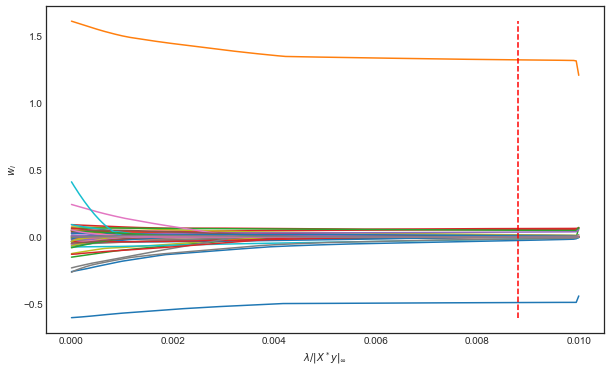

In [602]:
plt.clf
plt.figure(figsize=(10,6))
for i in np.arange(0,p):
    plt.plot(lambda_list/lmax, W[i,:])#, label=col_label[i]
plt.plot( [lambda0/lmax,lambda0/lmax], [W.flatten().min(),W.flatten().max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda/|X^* y|_\infty$')
plt.ylabel('$w_i$')
plt.legend()


- Le lasso apporte de bons résultats avec une erreur de prédiction qui passe de 20% avec la régression linéaire simple à environ 17% avec la sélection de variables Sparce.
- L’erreur diminue très rapidement avant d’atteindre un minimum. Dans cette zone, l’action de la régularisation éparse effectue la sélection de variables en éliminant rapidement celle qui n’apporte globalement que du bruit.
- L’erreur remonte progressivement ensuite avec une pente qui n’est pas constante. La corrélation importante entre les variables entraine une sélection de variables différentes selon les valeurs de lambda et certaine qui on disparue réapparaissent au fur à mesure que lambda augmente: La consistance de la selection n'est plus assurée.


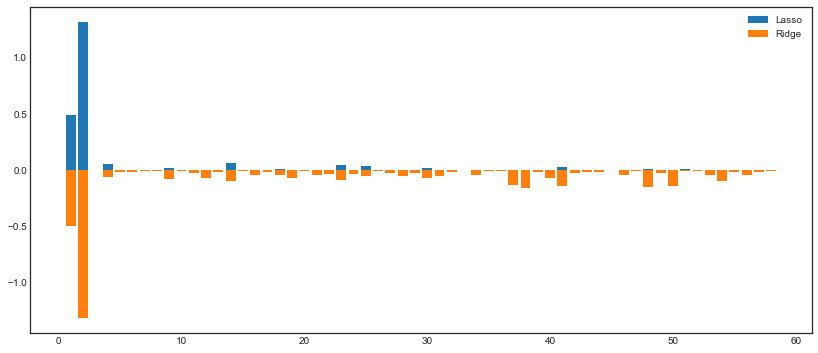

In [603]:
plt.clf
plt.figure(figsize=(14,6))
plt.bar(np.arange(1,p+1), abs(wSparse))
plt.bar(np.arange(1,p+1), -abs(wRidge))
plt.legend(('Lasso', 'Ridge'))


- Finalement, on observe ici le comportement de sélection parcimonieux du lasso qui a conservé beaucoup moins de variables que la régression Ridge.
- Même avec moins de variables les prédictions sont plus précises avec le lasso qui grâce à son comportement a réussi à éliminer des variables qui n’apportent rien au modèle.


# Regression Logistique (classification) - 2 classes

- Toujours avec le même jeu de données on cherche maintenant à prédire une variable catégorielle grâce à la régression logistique
- La variable cible est « Major_Nation » : cette variable binaire a été artificiellement créée à partir du jeu de donnée source. Elle vaut 1 quand la nationalité d’individu est au moins représentée 250 fois parmi tous les individus
- À noter que « théoriquement » la nationalité du joueur ne devrait pas avoir d’influence sur ses performances de jeux, en tous cas pour les joueurs du jeu de données qui sont tous de professionnel. Le choix de cette variable permettra, entre autre, de tester cela.
- Major_Nation est transformé le 0 devient -1
- Les autres variable catégorielles sont retirées

In [558]:
np.random.seed(11111)
df_FIFA2 = df_FIFA1.drop(['WorkRate2', 'Simple_Position','WorkRate1'], axis = 1)

#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]
# put y in +1 / -1 format
def format_y(y):
    if y == 0:
        return -1
    else:
        return 1

A = np.array(df_FIFA2)
A = A[np.random.permutation(A.shape[0]),:]

class_name_all = df_FIFA2.columns

mask = np.ones(class_name_all.shape[0],dtype=bool)

#retirer la target
mask[find(class_name_all == 'Major_Nation')[0]] = 0

y = MakeCol(A[:,find(class_name_all == 'Major_Nation')[0]])
y = MakeCol(np.array([format_y(yi) for yi in y]))
X = A[:,mask]


#retirer les variable catégories
#X_cat = X[:,44:]
X = X[:,:44]
[n,p] = X.shape

c = MakeCol(np.random.random_sample(X.shape[0]))

ech = .2

I0 = find(c>ech) # train
I1 = find(c<=ech) # test
n0 = I0.size
n1 = n-n0
X0 = X[I0,:]
y0 = y[I0]
X1 = X[I1,:]
y1 = y[I1]

#nomalisation du train
mX0 = X0.mean(axis=0)
sX0 = X0.std(axis=0)
X0 = (X0-mX0)/sX0
X1 = (X1-mX0)/sX0
m0 = y0.mean()
#y0 = y0-m0
#y1 = y1-m0

#remetre les variables catégorielles
#X0 = np.append(X0,X_cat[I0,:], axis=1)
#X1 = np.append(X1,X_cat[I1,:], axis=1)

Pour la régression logistique on cherche à minimiser l’énergie /  la fonction de loss  logistique suivante :
$$\min_{w} E(w) \equiv\frac{1}{n}\sum_{i=1}^n L(\langle x_i,w \rangle,y_i)$$
La loss logistique :
$$ L( s,y ) \equiv \log( 1+\exp(-sy) ) $$
On peut également utiliser d’autres fonctions de loss (binaire 0-1 ou hinge) illustrés dans la figure suivante :

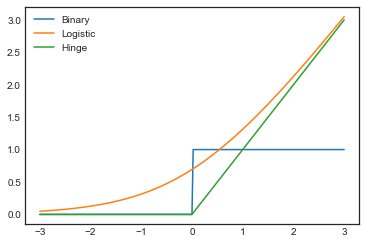

In [559]:
t = np.linspace(-3,3,255).transpose()
plt.clf
plt.plot(t, t>0)
plt.plot(t, np.log(1+np.exp(t)))
plt.plot(t, np.maximum(t,0) )
plt.axis('tight');
plt.legend(['Binary', 'Logistic', 'Hinge']);

Un biais est rajouté pour améliorer la performance (bien que le nombre de dimensions soit déjà relativement élevé).

De façon analogue aux algorithmes de la partie précédente, on effectue une descente de gradient pour minimiser la loss.

Descente de gradient : $$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$


In [560]:
#Loss
def L(s,y):  return 1/n * np.sum( np.log( 1 + np.exp(-s*y) ) )
def L_01(s,y):  return 1/n * sum((-s*y)>0)
#Energie pour fonction de pertes différentes
def E(w,X,y): return L(X.dot(w),y) #logistique 
def E_01(w,X,y): return L_01(X.dot(w),y) #binaire
def E_hinge(w,X,y):return 1/n*sum(np.maximum(np.zeros((len(y),1)),-(X.dot(w))*y)) #hinge

#Gradients
def theta(v): return 1 / (1+np.exp(-v))
def nablaL(s,y): return - 1/n * y * theta(-s * y)
def nablaE(w,X,y): return X.transpose().dot( nablaL(X.dot(w),y) )

def AddBias(X): return np.hstack(( X, np.ones((np.size(X,0),1)) ))

Calcule du tau max qui garantit une convergence de la descente de gradient :

In [561]:
tau_max = 2/(1/4 * np.linalg.norm(AddBias(X0))**2)
tau_max

1.3425296615146943e-05

On peux prendre un tau plus élevé pour diminuer nombre d'itérations (tout en vérifiant) que l'énergie converge bien.

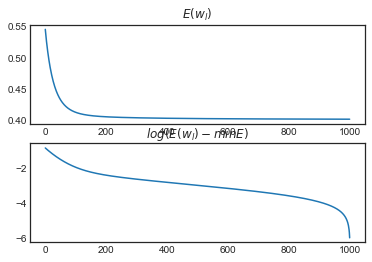

In [562]:
tau=.1
niter = 1000
Elist = np.zeros([niter,1])
w = np.zeros( (p+1,1) ) # initialization
for i in np.arange(0,niter):
    w = w - tau * nablaE(w,AddBias(X0),y0)
    Elist[i] = E(w,AddBias(X0),y0)
ndisp = int(niter)

## display ##
plt.clf
plt.subplot(2,1,1)
plt.plot(np.arange(0,ndisp), Elist[0:ndisp])
plt.axis('tight')
plt.title('$E(w_l)$')
plt.subplot(2,1,2);
plt.plot(np.arange(1,ndisp), np.log10(Elist[1:ndisp]-np.min(Elist))  )
plt.axis('tight')
plt.title('$log(E(w_l) - min E)$');
wIni = w

**Comparaison des loss sur le train et test :**

Loss sur le train : 

In [563]:
n = len(y0)
print('Loss Logistique:',E(w,AddBias(X0),y0))
print('Loss 0/1:',E_01(w,AddBias(X0),y0))
print('Loss hinge:',E_hinge(w,AddBias(X0),y0))

Loss Logistique: 0.505537296036037
Loss 0/1: [0.21786739]
Loss hinge: [0.25081919]


loss sur le test : 

In [564]:
n = len(y1)
print('Loss Logistique:',E(w,AddBias(X1),y1))
print('Loss 0/1:',E_01(w,AddBias(X1),y1))
print('Loss hinge:',E_hinge(w,AddBias(X1),y1))

Loss Logistique: 0.49786028863700815
Loss 0/1: [0.21287857]
Loss hinge: [0.24150222]


Le loss sur le train et le test sont très similaires. Cela peut provenir du fait que l’on ait beaucoup d’individus alors que les données ne sont pas forcément « très complexes » et probablement générées en partie de façon pseudo aléatoire. Ainsi l’algorithme à "bien apprit" avec le jeu d’entrainement et l’on retrouve des scores similaires sur le jeu de test.

In [565]:
pred = np.ceil(AddBias(X1).dot(w)-1) 
def format_y2(y):
    if y >= 0:
        return 1
    else:
        return -1
    
pred = MakeCol(np.array([format_y2(yi) for yi in pred]))
goodp = 0
for i in np.arange(0,len(pred)) : 
    if pred[i] == y1[i]:
        goodp = goodp + 1

print("% de bonnes prédictions :")
print(100*goodp/len(pred))


% de bonnes prédictions :
78.71214348720964


 Avec 79% de bonne prédiction, on obtient un score relativement élevé. Celui-ci est très proche de la loss 0/1 (avec biais). Nous tentons maintenant la régression logistique avec le lasso.

### Implementation du Lasso sur la regression logistique :

Comme précédement on utilise l'algorithme ISTA 

In [566]:
def J(w,Lambda): return L(AddBias(X).dot(w),y) + 1/len(w)*Lambda*np.linalg.norm(w,1)
def Soft(x,s): return np.maximum( abs(x)-s, np.zeros(x.shape)) * np.sign(x)
def ISTA(w,X,y,Lambda,tau): return Soft( w - tau * (X.transpose().dot( nablaL(X.dot(w),y))) , Lambda*tau )

18
Lasso: 49.755166554641114%


Text(0, 0.5, '$E$')

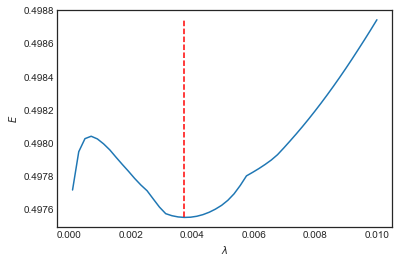

In [567]:
q = 50
lmax=1
tau=0.1
lambda_list = lmax*np.linspace(1e-4,1e-2,q)
W = np.zeros( (p+1,q) )
Elist = np.zeros( (q,1) )
w = np.zeros((p+1,1))
niter = 500
for iq in np.arange(0,q):
    Lambda = lambda_list[iq]
    # ISTA #
    for i in np.arange(0,niter):
        w = ISTA(w,AddBias(X0),y0,Lambda,tau)
    W[:,iq] = w.flatten() # bookkeeping
    Elist[iq] =  E(w,AddBias(X1),y1)
# find optimal Lambda
i = Elist.argmin()
print(i)
lambda0 = lambda_list[i]
wSparse = W[:,i]
print( 'Lasso: ' + str(Elist.min()*100) + '%' )
# Display error evolution.
plt.clf
plt.plot(lambda_list/lmax, Elist)
plt.plot( [lambda0/lmax,lambda0/lmax], [Elist.min(),Elist.max()], 'r--')
plt.axis('tight')
plt.xlabel('$\lambda $')
plt.ylabel('$E$')


In [568]:
pred = np.ceil(AddBias(X1).dot(wSparse)-1) 
def format_y2(y):
    if y >= 0:
        return 1
    else:
        return -1
    
pred = MakeCol(np.array([format_y2(yi) for yi in pred]))
goodp = 0
for i in np.arange(0,len(pred)) : 
    if pred[i] == y1[i]:
        goodp = goodp + 1

print("% de bonnes prédictions :")
print(100*goodp/len(pred))

% de bonnes prédictions :
78.74154660394002


La régularisation sparse permet de diminuer la loss et d’améliorer la prédiction  de façon très marginale.

No handles with labels found to put in legend.


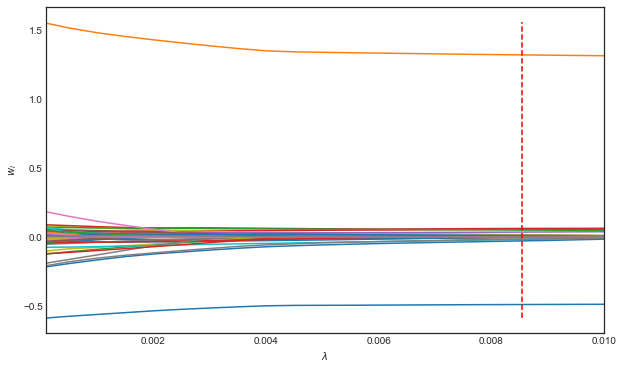

In [605]:
plt.figure(figsize=(10,6))
plt.clf
for i in np.arange(0,p):
    plt.plot(lambda_list/lmax, W[i,:])
plt.plot( [lambda0/lmax,lambda0/lmax], [W.flatten().min(),W.flatten().max()], 'r--')
plt.axis('tight')
plt.xlim(1e-4,1e-2)
plt.xlabel('$\lambda $')
plt.ylabel('$w_i$')
plt.legend()


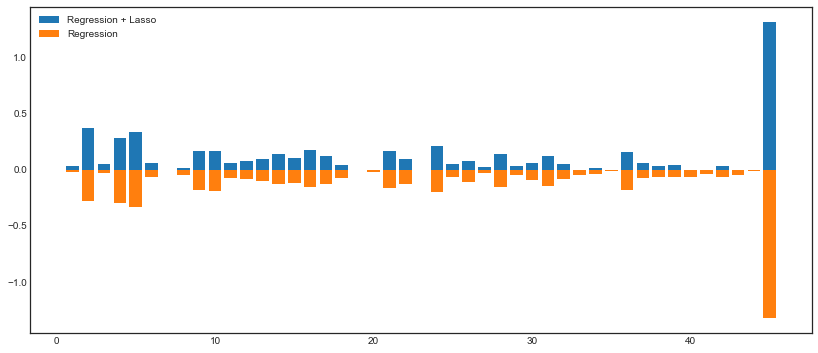

In [570]:
plt.clf
plt.figure(figsize=(14,6))
plt.bar(np.arange(1,p+2), abs(wSparse))
plt.bar(np.arange(1,p+2), -abs(wIni.flatten()))
plt.legend(('Regression + Lasso', 'Regression'))

La régression logistique arrive à prédire si un joueur fait partie d’une « nation majeur » avec un score élevé (79%). Cela laisse penser qu’il existe des tendances dans caractéristique (physique, performance, etc) des joueurs selon leur pays d’origine.


Idée pour aller plus loin:
- S’intéresser à comprendre et quantifier l’importance des variables, les différences de distribution selon les classes de Major Nation, etc.
- Implémenter dans la regression et dans la régularisation une optimisation en fonction des loss binaire ou Hinge voir si cela améliore le résultat.
  
    

## Conclusion 

Nous avons implémenté et testé plusieurs algorithmes de régression et de régularisation qui nous ont permis de comprendre :
- L’impact du choix de Ridge ou sparce pour la sélection de variables
- Les limites de la régularisation pour améliorer les performances de prédiction que le nombre d’individus est bien plus élevées que le nombre de variables
- Le fonctionnement de ces algorithmes et des mécanismes de descente de gradient indispensable pour la convergence des différentes méthodes utilisées ici.
